## Calculating the analytical solution for the oscillating basin

Author: WaveHello <br>
Last Modified: 06/24/2024 <br>

**Purpose**: <br>
Setup the boundary conditions and run the xBeach model to recreate the oscillating basin model. This file will run the model that is in the same directory.

**Link to the xBeach Non-Hydrostatic manual** <br>
[Link](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)

In [ ]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [ ]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis


In [ ]:
# Import library functions
sys.path.append(r"C:\ERDC\tutorial_models")
from lib.oscillating_wave_funcs import (calc_wave_number, calc_linear_dispersion_relation,
                                        calc_surface_elevation, calc_U_velocity, calc_V_velocity,
                                        )
from lib.os_functions import (write_2d_arr_2_file)
from lib.general_functions import find_closest_value_index

In [ ]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

In [ ]:
L = 100 # Length, [m]
g = 9.81 # gravity, [m/s^2]

# wave numbers for the different directions
k_x = PI/L
k_y = PI/L

k = calc_wave_number(k_x, k_y)

relative_depth = 0.5 # k/H 

H = relative_depth/k # Water depth, [m]

# Using the period from desmos (two subquential upcrossings) 
# Should be 14
wave_period = 20

omega = calc_linear_dispersion_relation(k, g, H) # Dispersion relation, angular velocity

print("Still water depth (H): {:.5f}".format(H))
print("Directional wave numbers, x: {:.2f}, y: {:.2f} ".format(k_x, k_y))
print("Wave number magnitude: {:.3f}".format(k))
print("Depth: {:.3f}".format(H))
print("Dispersion relation: {:.3f}".format(omega))

In [20]:
# Set bathy grid
nx = 150; ny = 150
num_analy_timestep = 1000

# Construct the x-coordinates
x = np.linspace(0, L, nx + 1)

# Construct the y-coordinates
y = np.linspace(0, L, ny + 1)

total_time = 8 * wave_period
time = np.linspace(0, total_time, num_analy_timestep)

# Make the grid
X, Y, T = np.meshgrid(x, y, time, indexing = "ij")

# Calc the surface elevation
eta = calc_surface_elevation(H, k_x, k_y, X, Y, T, omega)

# Calc the x velocity
U = calc_U_velocity(H, g, k_x, k_y, H, X, Y, T, omega)

# Calc the y velocity
V = calc_V_velocity(H, g, k_x, k_y, H, X, Y, T, omega)

print("Model time: {}".format(total_time))

Model time: 160


In [21]:
# Calc the values on the boundaries

# Select the slice you need
U_slice = U[0, :, :]
V_slice = V[0, :, :]
eta_slice = eta[0, :, :]

# Transpose to get time as the first dimension
U_slice_T = U_slice.T
V_slice_T = V_slice.T
eta_slice_T = eta_slice.T

# Stack U, V, and eta slices column-wise
# Shift the surface elevation so that it's only the pertubation
data = np.column_stack((time, U_slice_T, V_slice_T, eta_slice_T))

file_name =  "boun_U.bcf"
# Write the header and the data to a file
with open(file_name, 'w') as file:
    file.write("vector\n")
    file.write("4\n")
    file.write("t U V Z\n")
    np.savetxt(file, data, delimiter=' ', fmt='%10.5f')


print("Data written to {}".format(file_name))

Data written to boun_U.bcf


### Data
Generate and plot the bathymetry

In [22]:
# Generate the grid
xgr, ygr = np.meshgrid(x, y)

# Calc the bathymetry as -H
zgr = np.ones((nx + 1, ny + 1)) * -H

In [23]:
write_arrays = [xgr, ygr, zgr]
write_filename = ['x.grd', 'y.grd', 'bed.dep']

# Write the arrays to the specified files
for arr, filename in zip(write_arrays, write_filename):
    write_2d_arr_2_file(arr, filename)

2D array values have been written to x.grd
2D array values have been written to y.grd
2D array values have been written to bed.dep


In [24]:
# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

Model directory is: c:\ERDC\tutorial_models\oscillating_basin\9_oscillating_tstop_160_nxy_300_bc_neumann


In [25]:
# Specify the path to your batch file
batch_file = os.path.join(model_dir, r"run_model.bat")

# Run the batch file
try:
    subprocess.run(batch_file, check=True, shell=True)
    print(f"Batch file '{batch_file}' executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while executing the batch file: {e}")

Batch file 'c:\ERDC\tutorial_models\oscillating_basin\9_oscillating_tstop_160_nxy_300_bc_neumann\run_model.bat' executed successfully.


In [27]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


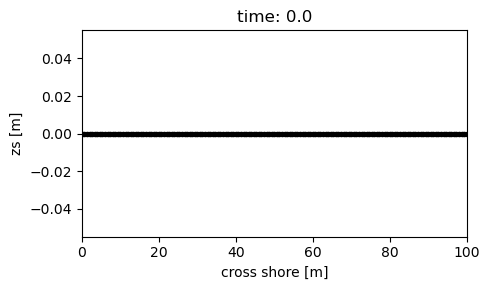

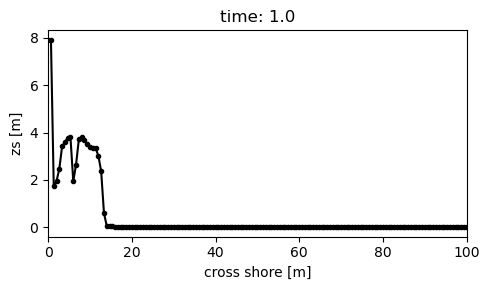

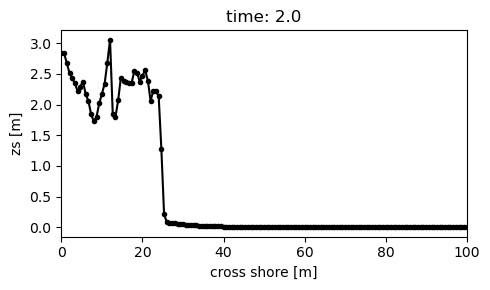

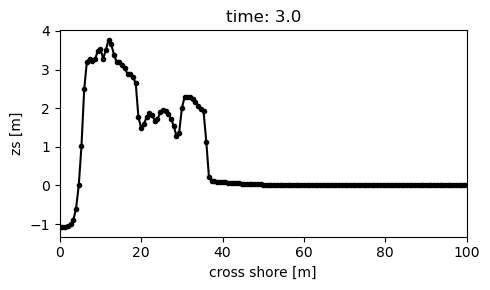

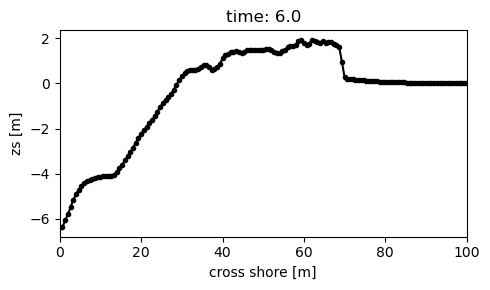

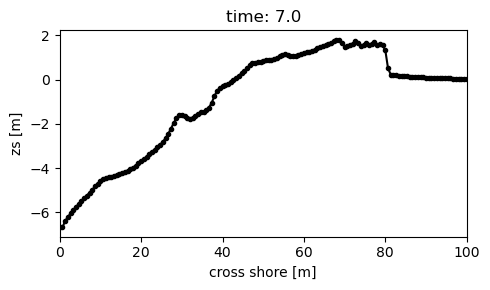

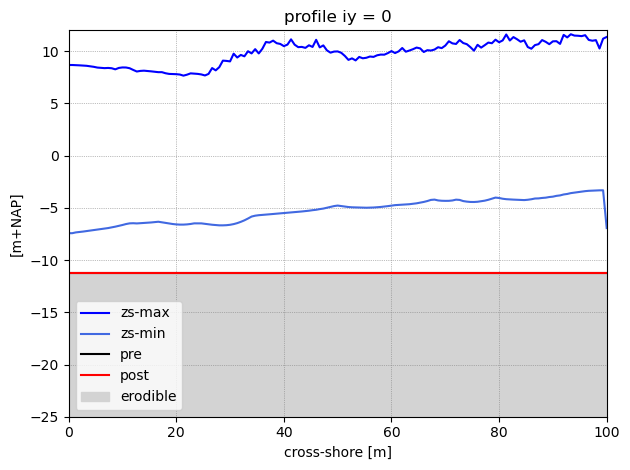

In [28]:
indices = [0, 10, 20, 30, 60, 70]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

(1601, 151, 151)


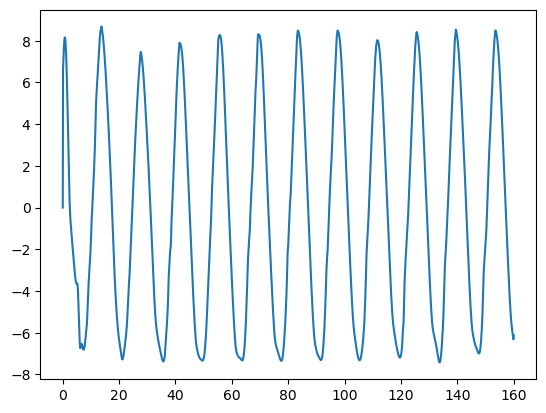

In [29]:
model_time = results.var["globaltime"]

zs = results.var["zs"]
print(np.shape(zs))

zs_0 = results.var["zs"][:, 1, 1]
plt.plot(model_time, zs_0)


In [30]:

t_over_T_times = np.array([4, 4.2, 4.3, 4.5])

indices = []

for t in t_over_T_times:
    # Get the closest index
    indices.append(find_closest_value_index(model_time/wave_period, t))

Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


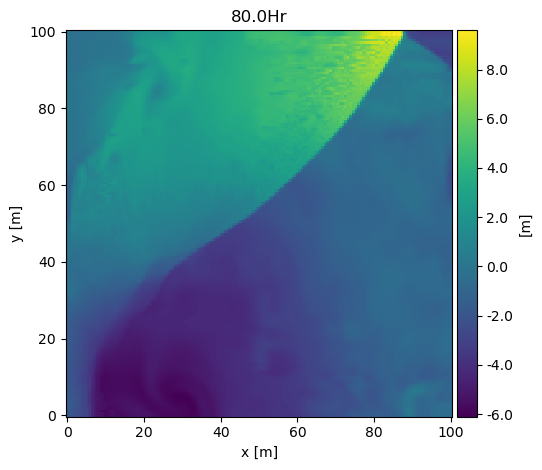

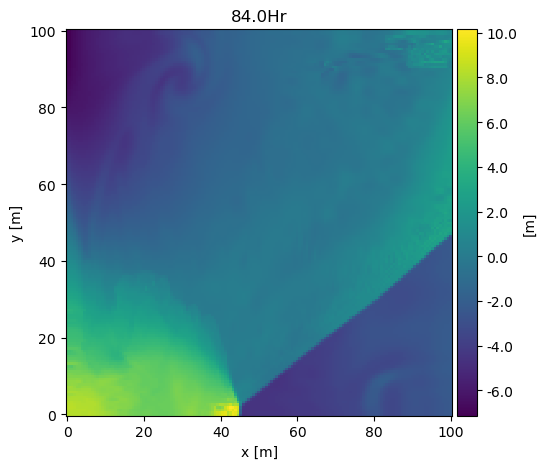

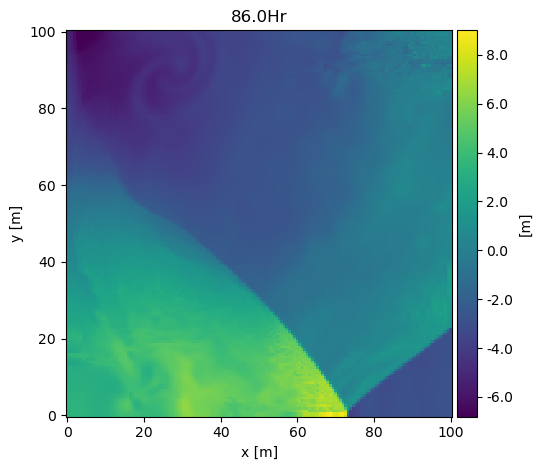

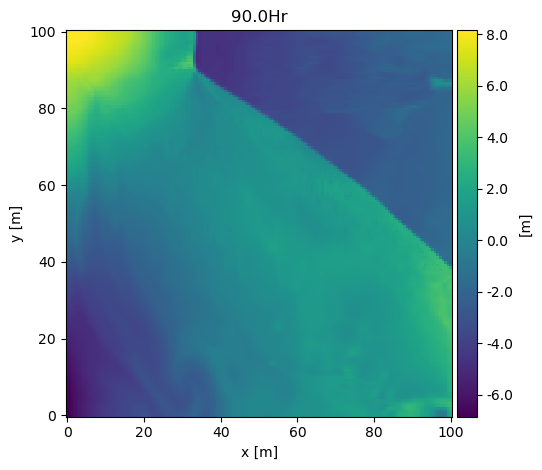

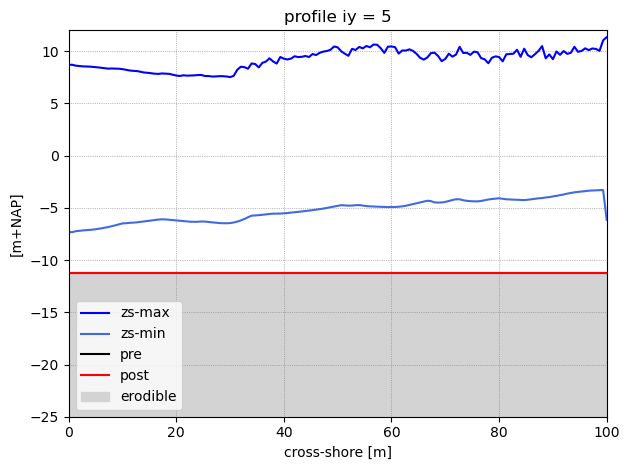

In [32]:
## change coordinates of plots to local coordinates:
#results.set_plot_localcoords(True)
## only plot a certain Area Of Interest of the complete grid
#results.set_aoi([20,445,20,220])

# example usage map plotting

# indices = [0, 25, 50, 75, 100, 200, 400]
for index in indices:
    fig, ax = results.fig_map_var('zs','[m]', it = index)

#fig, ax = results.fig_map_diffvar('zb', '$\Delta z_b$ [m]')

# fig, ax = results.fig_cross_var('H', 2, iy=5, coord=None, plot_ref_bathy=True, zmin=-25)

fig, ax = results.fig_profile_change(iy=5)